In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
BA= nx.random_graphs.barabasi_albert_graph(100,1)  #生成n、m=1的BA无标度网络
pos = nx.spring_layout(BA)          #定义一个布局，此处采用了spring布局方式
nx.draw(BA,pos,with_labels=False,node_size = 30)  #绘制图形
plt.show()

G = nx.scale_free_graph(200)
pos = nx.kamada_kawai_layout(G)
nx.draw(G,pos,with_labels=False,node_size = 30) 
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

MG = nx.scale_free_graph(20)
pos = nx.kamada_kawai_layout(MG)
nx.draw(MG,pos,with_labels=False,node_size = 30) 
plt.show()

G = nx.DiGraph()
GG = nx.to_directed(MG)
pos = nx.kamada_kawai_layout(GG)
nx.draw(GG,pos,with_labels=False,node_size = 30) 
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
def mulDiGraph2DiGraph(M):
    # create weighted graph from M
    G = nx.DiGraph()
    for u,v,data in M.edges(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G.has_edge(u,v):
            G[u][v]['weight'] += w
        else:
            G.add_edge(u, v, weight=w)
    return G;

N = 20
MG = nx.scale_free_graph(N)
pos = nx.kamada_kawai_layout(MG)
nx.draw(MG,pos,with_labels=False,node_size = 30) 
plt.show()

G = mulDiGraph2DiGraph(MG)
pos = nx.kamada_kawai_layout(G)
nx.draw(G,pos,with_labels=False,node_size = 30) 
plt.show()

In [ ]:
G.out_degree()
4 1 1 5 1 3 1 1 1 1 
0 0 2 2 1 0 1 1 1 1

after loading graph from pickle
after setting graph attributes


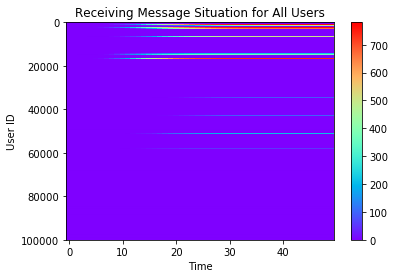

100000 50


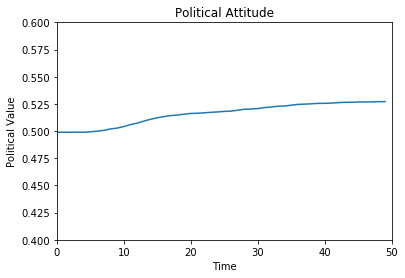

1503


In [6]:
import datetime

starttime = datetime.datetime.now()

%run informationFlow.py

endtime = datetime.datetime.now()

print ((endtime - starttime).seconds)

In [ ]:
poliRed

In [ ]:
poliBlue[0, 1:20]

In [ ]:
poliRed[0, 1:20]

In [ ]:
Rec.shape

42


In [8]:
import networkx as nx
import pickle
import datetime

def mulDiGraph2DiGraph(M):
    # create weighted graph from M
    G = nx.DiGraph()
    for u,v,data in M.edges(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G.has_edge(u,v):
            G[u][v]['weight'] += 0
        else:
            G.add_edge(u, v, weight=0)
    return G;


starttime = datetime.datetime.now()
popNum = 2000
sourceNum = 20
Gra = nx.scale_free_graph(popNum)
Gra = mulDiGraph2DiGraph(Gra)
nx.write_gpickle(Gra, './Graph2k.pickle')

endtime = datetime.datetime.now()

print ((endtime - starttime).seconds)

1


In [4]:
Gra = nx.read_gpickle('./Graph100k.pickle')

after loading graph from pickle
after setting graph attributes


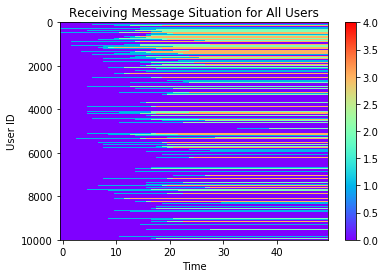

10000 50


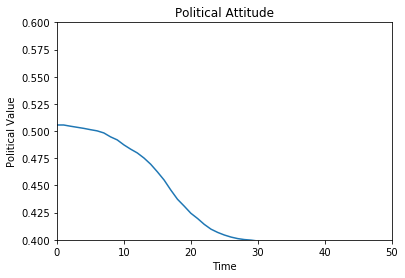

6


In [5]:
import datetime

starttime = datetime.datetime.now()

%run informationFlow.py

endtime = datetime.datetime.now()

print ((endtime - starttime).seconds)

after loading graph from pickle


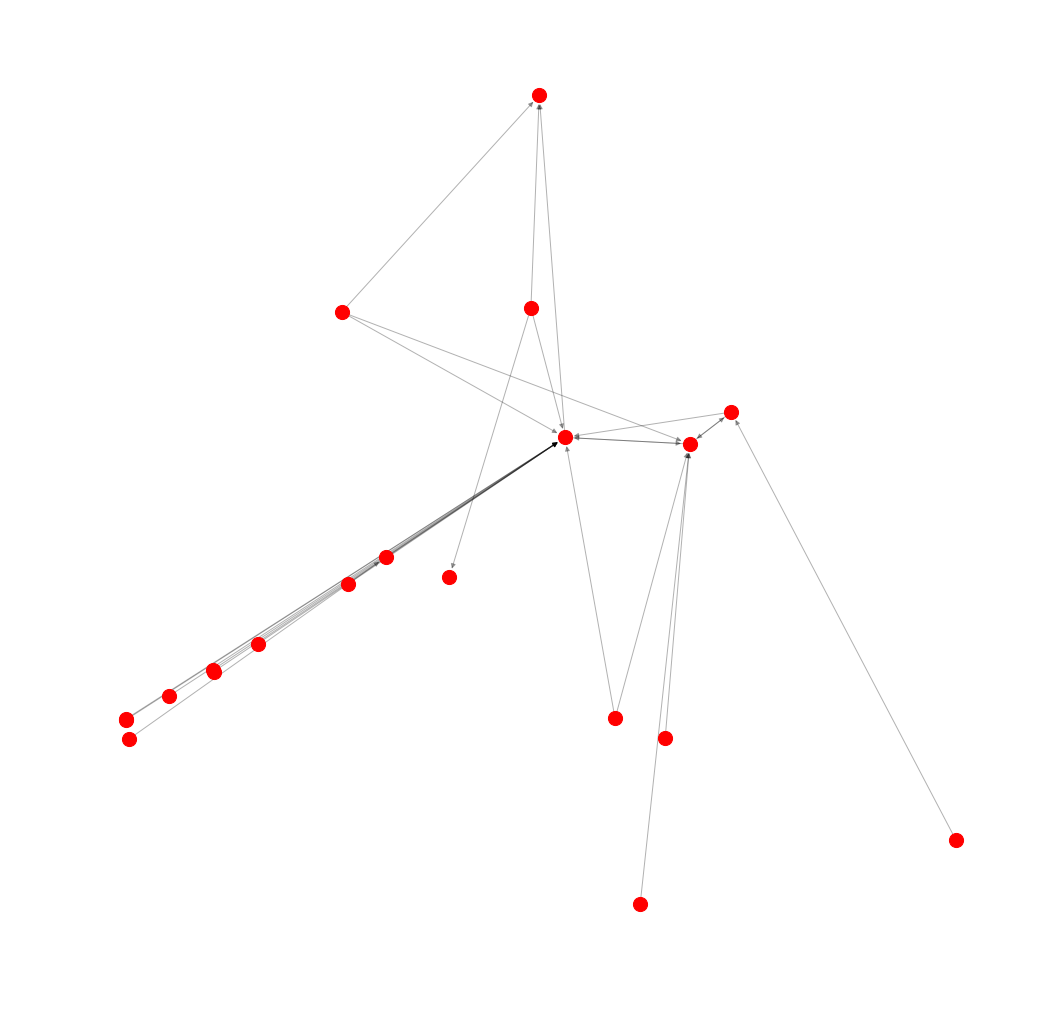

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
from random import *
import pickle

class Net(object):
    def __init__(self,G):
        self.Num = nx.number_of_nodes(G)
        self.PersonList = nx.nodes(G)
        self.EdgeList = nx.edges(G)
        self.G = G
  
        # 随机生成各个点的政治属性
        self.policy = {node:random() for node in self.PersonList}
        nx.set_node_attributes(self.G,self.policy,name='policy') # 均匀分布（可调试）
        # 随机生成每条边的延迟时间
        self.delayTime = {edge:randint(1,10) for edge in self.EdgeList}
        nx.set_edge_attributes(self.G,self.delayTime,name='weight')
        # 随机生成每条边的激活概率
        self.Eprob= {edge:random() for edge in self.EdgeList}
        nx.set_edge_attributes(self.G,self.Eprob,name='Eprob')
        
        # 根据延迟时间布局
        self.pos=nx.kamada_kawai_layout(self.G,weight='weight') # positions for all nodes

    def Spread(self, sourceList, poliTendency):
        '''
        输入消息源头,
        返回Rec[PersonNum][Time]表示person在t时刻**总共**接收到的消息数
        返回poliRed[PersonNum][Time]表示person在**t时刻**接收到的红营推送数
        返回poliBlue[PersonNum][Time]表示/// 蓝///
        '''
#         对于每一个消息源头,先随机生成一次图
#         根据随机生成的图跑一次最短路径算法
#         得到每一个节点收到消息的时间,没收到用大数表示
        MaxTime = 50
        Rec = np.zeros([self.Num,MaxTime])
        politicRed =  np.zeros([self.Num,MaxTime])
        politicBlue = np.zeros([self.Num,MaxTime])
        count = 0
        for source in sourceList:
            weightn = {}
            # 模拟只传播一次
            for edge in self.EdgeList:
                weightn[edge] = self.delayTime[edge] if random()>self.Eprob[edge] else Inf
            nx.set_edge_attributes(self.G,weightn,name='weightn')
            SpreadTime = nx.shortest_path_length(self.G,source=source,weight='weightn')
            for (person,time) in SpreadTime.items():
                if time < MaxTime:
                    Rec[person][time:] += 1 
                    if poliTendency[count] == 1:
                        politicRed[person][time] += 1
                    else:
                        politicBlue[person][time] += 1
            count += 1
        return Rec, politicRed, politicBlue
    
    def Change(self,Rec, politicRed, politicBlue):
        '''
        输入各个时刻的收到的消息数
        返回各个时刻的政治立场
        '''
        m,n = Rec.shape
        PoliChange = np.zeros([m,n])
        print(m, n)
        for person in self.PersonList:
            PoliChange[person, 0] = self.policy[person]
        # PoliChange[:, 1:] = np.minimum(1, PoliChange[:, 0:-1] + 0.05 * Rec[:, 1:])
        for t in range(n - 1):
            PoliChange[:, t + 1] = np.minimum(1, PoliChange[:, t] + 0.1 * politicRed[:, t + 1] - 0.1 * politicBlue[:, t + 1]) # 越靠近1约red
            
        # TODO: 
        # 这里的改变我直接粗暴的乘了0.05
        # 这个函数需要好好想想
        # p.s. 上面这句话怎么向量化。。。 如何用generator遍历dict?
        PoliMap = np.zeros(n)
        for t in range(n):
            PoliMap[t] = len(np.where(PoliChange[:, t] < 0.5)[0])
        
        return PoliMap / self.Num

    
    def Show(self):
        plt.figure(figsize=(18,18))  
        nx.draw_networkx_edges(self.G,self.pos,alpha = 0.3)  
        nx.draw_networkx_nodes(self.G,self.pos,nodelist=self.policy.keys(),  
                       node_size=200,  
                       cmap=plt.cm.RdBu)  
        plt.axis('off')
        plt.show()

    

        
def mulDiGraph2DiGraph(M):
    # create weighted graph from M
    G = nx.DiGraph()
    for u,v,data in M.edges(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G.has_edge(u,v):
            G[u][v]['weight'] += 0
        else:
            G.add_edge(u, v, weight=0)
    return G;

popNum = 20
sourceNum = 100

# Gra = nx.fast_gnp_random_graph(popNum,0.05,seed=None,directed=True)
Gra = nx.scale_free_graph(popNum)
Gra = mulDiGraph2DiGraph(Gra)
print("after loading graph from pickle")
net = Net(Gra)
net.Show()

after loading graph from pickle
after setting graph attributes
[211, 1487, 612, 1277, 1748, 559, 1678, 170, 924, 999, 1008, 1367, 1385, 128, 1416, 756, 731, 1681, 452, 827, 1909, 870, 1243, 1604, 1358, 340, 114, 857, 410, 429, 194, 1520, 1199, 513, 1528, 1488, 1992, 21, 1914, 1990, 84, 1962, 331, 1808, 914, 1729, 1077, 748, 1375, 1094, 1903, 1486, 435, 1710, 188, 731, 1177, 938, 1881, 1694, 87, 1553, 174, 1149, 571, 1855, 1160, 474, 351, 1167, 782, 1077, 653, 901, 1201, 1403, 762, 1312, 1216, 117, 1831, 520, 1898, 1782, 45, 599, 9, 612, 1937, 1575, 567, 1448, 1137, 1992, 487, 1205, 1801, 1983, 665, 324]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 50


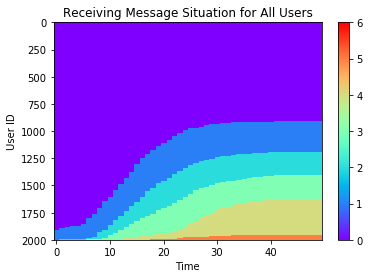

2000 50


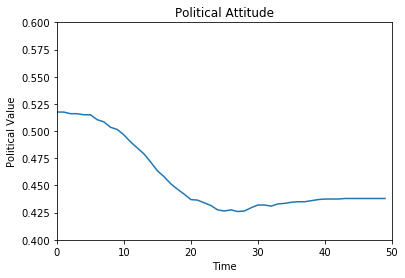

1


In [49]:
import datetime

starttime = datetime.datetime.now()

%run informationFlow.py

endtime = datetime.datetime.now()

print ((endtime - starttime).seconds)

In [18]:
a = np.array([7, 8, 9, 4, 5, 6]).reshape([2, 3])

In [11]:
a


array([[1, 2, 3],
       [4, 5, 6]])

In [23]:
print(a)
print(np.sort(a, axis=0))

[[7 8 9]
 [4 5 6]]
[[4 5 6]
 [7 8 9]]


In [37]:
np.append(a, a)

array([7, 8, 9, 4, 5, 6, 7, 8, 9, 4, 5, 6])